Please enter the stock ticker symbol (Please include ^ for market indices):  ^GSPC


,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2003-01-02 00:00:00-05:00,879.820007,909.030029,879.820007,909.030029,1229200000,908.590027,0
2003-01-03 00:00:00-05:00,909.030029,911.250000,903.070007,908.590027,1130800000,929.010010,1
2003-01-06 00:00:00-05:00,908.590027,931.770020,908.590027,929.010010,1435900000,922.929993,0
2003-01-07 00:00:00-05:00,929.010010,930.809998,919.929993,922.929993,1545200000,909.929993,0
2003-01-08 00:00:00-05:00,922.929993,922.929993,908.320007,909.929993,1467600000,927.570007,1
...,...,...,...,...,...,...,...
2023-08-17 00:00:00-04:00,4416.319824,4421.169922,4364.830078,4370.359863,3943700000,4369.709961,0
2023-08-18 00:00:00-04:00,4344.879883,4381.819824,4335.310059,4369.709961,3940400000,4399.770020,1
2023-08-21 00:00:00-04:00,4380.279785,4407.549805,4360.299805,4399.770020,3726850000,4387.549805,0


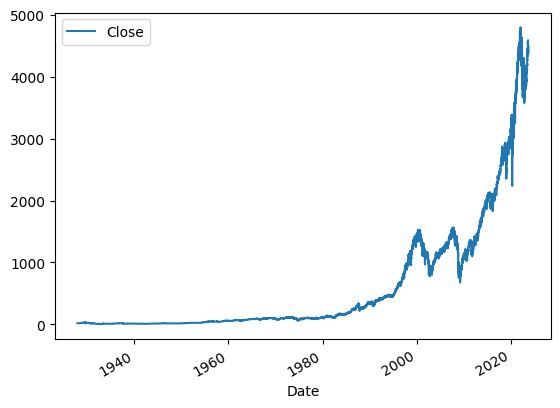

In [26]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from collections import OrderedDict
import matplotlib.pyplot as plt

ticker = input("Please enter the stock ticker symbol (Please include ^ for market indices): ")
sp500 = yf.Ticker(f"{ticker}")
sp500 = sp500.history(period="max")
sp500.plot.line(y="Close", use_index=True)

if "Dividends" in sp500.columns:
    del sp500["Dividends"]
if "Stock Splits" in sp500.columns:
    del sp500["Stock Splits"]

sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500 = sp500.loc["2003-01-01":].copy()
sp500

In [27]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .60] = 1
    preds[preds < .60] = 0
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

def backtest(data, model, predictors, start=250, step=63):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i: (i + step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

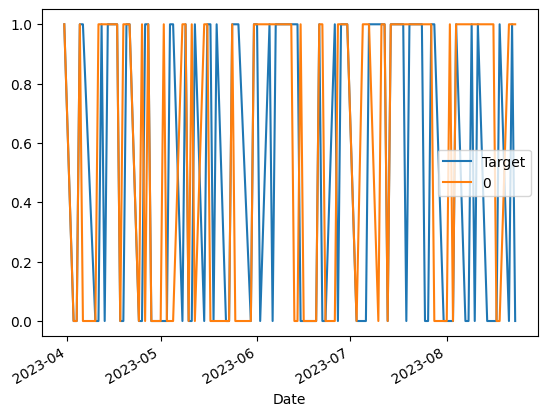

In [12]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]
predictors = ["Close", "Volume", "High", "Low"]
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

predictions = backtest(sp500, model, predictors)

Precision Score: 0.5901639344262295


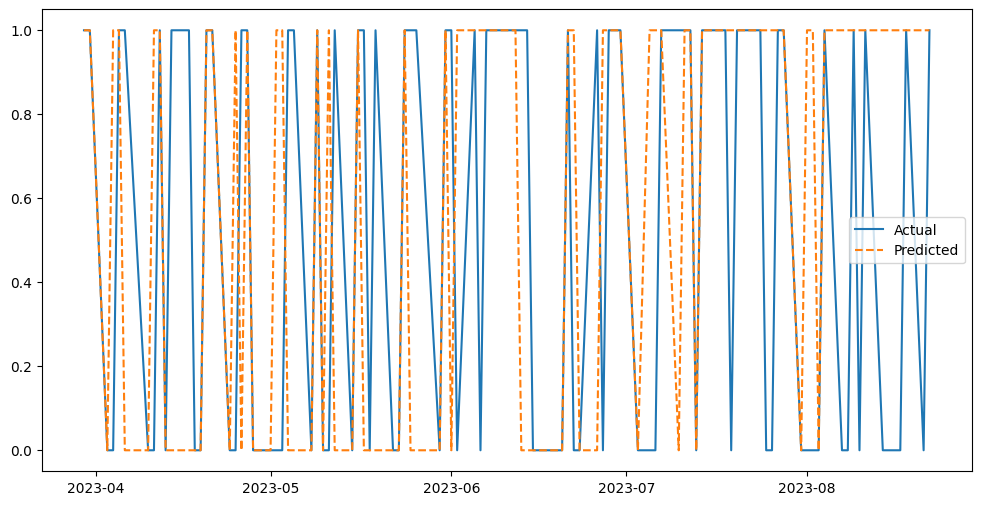

In [28]:
horizons = [2, 5, 60, 250, 2000]
new_predictors = []
for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    new_predictors += [ratio_column, trend_column]

sp500.dropna(inplace=True)

# Check if there are enough samples for training
if sp500.shape[0] > 100:
    train = sp500.iloc[:-100].copy()
    test = sp500.iloc[-100:].copy()
    predictors = ["Close", "Volume", "High", "Low"]
    target_column = "Target"
    if train[predictors].shape[0] > 0 and train[target_column].shape[0] > 0:
        model = RandomForestClassifier(n_estimators=200, min_samples_split=25, random_state=1)
        model.fit(train[predictors], train[target_column])
        preds = model.predict(test[predictors])
        # Further analysis or evaluation here
        
        # Calculate precision score
        precision = precision_score(test[target_column], preds)
        print(f"Precision Score: {precision}")
        
        # Plot predicted vs actual values
        plt.figure(figsize=(12, 6))
        plt.plot(test.index, test[target_column], label="Actual")
        plt.plot(test.index, preds, label="Predicted", linestyle='dashed')
        plt.legend()
        plt.show()

    else:
        print("Training data is empty. Check your data preprocessing and slicing.")
else:
    print("Not enough samples in the dataset for training and testing.")

In [29]:
investment_horizons = [10, 20, 63]  # 2 weeks, 1 month, 1 quarter

for horizon in investment_horizons:
    target_column = f"Target_{horizon}"
    sp500.loc[:, target_column] = (sp500["Close"].shift(-horizon) > sp500["Close"]).astype(int)

In [30]:
investment_horizons = [10, 20, 63]  # 2 weeks, 1 month, 1 quarter
# Store the likelihoods for each time frame
profit_likelihoods = OrderedDict({
    "2_weeks": None,
    "1_month": None,
    "1_quarter": None
})
time_frames = list(profit_likelihoods.keys())

threshold = 0.5 # Adjust this threshold as needed

for idx, horizon in enumerate(investment_horizons):
    target_column = f"Target_{horizon}"
    train = sp500.iloc[:-100].copy()
    test = sp500.iloc[-100:].copy()
    model = RandomForestClassifier(n_estimators=200, min_samples_split=25, random_state=1)
    model.fit(train[new_predictors], train[target_column])
    preds_proba = model.predict_proba(test[new_predictors])[:,1]

    # Calculate the likelihood of profit for the corresponding time frame
    profit_likelihoods[time_frames[idx]] = (preds_proba > threshold).mean()

# Output the likelihood of profit
for time_frame, likelihood in profit_likelihoods.items():
    print(f"The likelihood of making a profit in the next {time_frame} is {likelihood * 100}%.")

The likelihood of making a profit in the next 2_weeks is 46.0%.
The likelihood of making a profit in the next 1_month is 52.0%.
The likelihood of making a profit in the next 1_quarter is 79.0%.
